In [31]:
import sys
sys.path.append('..')

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [22]:
os.listdir('train')

['bathroom',
 'bedroom',
 'dining',
 'entryway',
 'kitchen',
 'living',
 'office',
 'outdoor']

## you can normalize images and shit in here too if u want idk

In [23]:
class Data(torch.utils.data.Dataset):
    def __init__(self, image_size):
        self.data = []
        self.labels = []
        self.dir = 'train'
        
        i = 0
        for folder in os.listdir(self.dir):
            label = i
            for file in tqdm(os.listdir(os.path.join(self.dir, folder))):
                img_path = os.path.join(os.path.join(self.dir, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.resize(image, image_size)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = np.reshape(image, [3, 224, 224])
                 
                # Append the image and its corresponding label to the output
                self.data.append(image)
                self.labels.append(label)
            i += 1
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [24]:
data = Data((224, 224))

100%|█████████████████████████████████████████████████████████████████████████████| 3210/3210 [00:31<00:00, 101.74it/s]


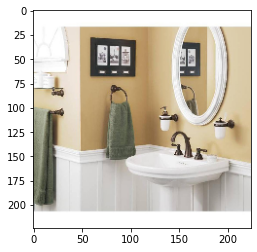

In [29]:
plt.imshow(data[0][0].reshape(224, 224, 3))

In [32]:
from vit.pls import *

In [37]:
params = {'input_channels':3, 'dim':768, 'hidden_dim':3072, 'patch_size':16, 'img_size':224, 'num_layers':12, 
          'dropout':0.0, 'attention_dropout':0.0, 'num_heads':12, 'fine_tune':8, 'num_classes':21843}

In [38]:
model = VisionTransformer(**params)

In [39]:
device = torch.device('cuda:0')
model.load_state_dict(torch.load('../lasthope.pth', map_location=device), strict=False)

_IncompatibleKeys(missing_keys=['patch_embed.weight', 'patch_embed.bias', 'ft.weight', 'ft.bias'], unexpected_keys=['norm.weight', 'norm.bias', 'patch_embed.proj.weight', 'patch_embed.proj.bias'])

In [41]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()

In [42]:
len(data)

25524

In [44]:
train, val = torch.utils.data.random_split(data, [22972, 2552])

In [45]:
trainloader = torch.utils.data.DataLoader(train, batch_size=16, num_workers=8, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=16, num_workers=8, shuffle=True)

In [53]:
test_img = torch.tensor(data[0][0], device=device, dtype=torch.float32).unsqueeze(0)

In [54]:
kek = model(test_img)

In [59]:
torch.argmax(kek) # dumb ass vit lmfao

tensor(2, device='cuda:0')

In [ ]:
avg_tloss, avg_vloss = [], []

for e in range(100):
    t_loss, v_loss = [], []
    for x, y in trainloader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred = model(x.float())
        l = loss(y_pred, y)
        npl = l.detach().cpu().numpy()
        l.backward()
        optimizer.step()
        t_loss.append(npl)
        
    with torch.no_grad():    
        for x, y in valloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x.float())
            l = loss(y_pred, y)
            npl = l.detach().cpu().numpy()
            v_loss.append(npl)
    
    avg_tloss.append(np.mean(t_loss))
    avg_vloss.append(np.mean(v_loss))
    
    print(f'Epoch: {e}, Training Loss: {np.mean(t_loss)}, Validation Loss: {np.mean(v_loss)}')